In [2]:
import ccxt
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd

def get_historical_data(since, market, resolution):
  exchange = ccxt.ftx({'enableRateLimit': True})
  since = exchange.parse8601(f"{since}T00:00:00Z")
  params = {'market_name': market}  # https://github.com/ccxt/ccxt/wiki/Manual#overriding-unified-api-params
  limit = None
  # specify any existing symbol here ↓ (it does not matter, because it is overrided in params)
  ohlcv = exchange.fetch_ohlcv(market, resolution, since, limit, params)
  return ohlcv

def ls_index(start_date, long, short, resolution):
  try:
    s = read_historical_data(start_date, short, resolution)
    l = read_historical_data(start_date, long, resolution)
  except FileNotFoundError as e:
      s_name = download_historical_data(start_date, short, resolution)
      l_name = download_historical_data(start_date, long, resolution)
      s = read_historical_data(start_date, short, resolution)
      l = read_historical_data(start_date, long, resolution)
  df = pd.DataFrame(columns=['time','l','s'])
  df['time'] = s['time']
  df['s'] = s['close']
  df['l'] = l['close']
  df['ls'] = df['l'] / df['s']
  df['returns'] = df['ls'] / df['ls'][0]
  
  return df

def download_historical_data(start_date, ticker, resolution):
    data = get_historical_data(start_date, ticker, resolution)
    file_name = f"data/{ticker}_{resolution}_{start_date}.csv"
    df = pd.DataFrame(data, columns=['time','open','high','low','close','volume'])
    df.to_csv(file_name)
    return file_name

def read_historical_data(start_date, ticker, resolution):
    data = pd.read_csv(f"data/{ticker}_{resolution}_{start_date}.csv")
    return pd.DataFrame(data, columns=['time','open','high','low','close','volume'])

def compare(date, t1, res="1h",long=False,tickers = ["BTC","ETH","LUNA", "SOL","AVAX","BNB","MATIC","NEAR","ATOM","ADA"]):
  sz = int(len(tickers) / 2)
  fig, axs = plt.subplots(2,sz,figsize=(20,15))
  
  info_list = list()
  if long:
    for i in range(len(tickers)):
      df = ls_index(date, t1, tickers[i]+"-PERP", res)
      long = t1.removesuffix("-PERP")
      axs[int(i/sz)][int(i%sz)].set_title(f"{long}/{tickers[i]}")
      axs[int(i/sz)][int(i%sz)].plot(df['time'], df['returns'])     
      max, min, cur = analyze(df,t1,tickers[i])
      info_list.append([f"{long}/{tickers[i]}",max,min,cur])
      
    plt.show()
  
        
  else:
      for i in range(len(tickers)):
        df = ls_index(date, tickers[i]+"-PERP",t1, res)
        long = t1.removesuffix("-PERP")
        axs[int(i/sz)][int(i%sz)].set_title(f"{tickers[i]}/{long}")
        axs[int(i/sz)][int(i%sz)].plot(df['time'], df['returns'])     
        max, min, cur = analyze(df,t1,tickers[i])
        info_list.append([f"{tickers[i]}/{long}",max,min,cur])
    
  info = pd.DataFrame(info_list,columns=['pair','max_drawdown','max_return','current_return'])
  return info
    
def analyze(df,t1,t2):
    
    size = len(df) 
    # print(f"In {size} hours ({round(size/24)} days), {t1.removesuffix('-PERP')}/{t2} returned {round((df.iloc[size-1]['returns'] - 1) * 100,2)}%")
    maxdrawdown =  round((min(df['returns']) - 1 )*100,2)
    max_return =  round((max(df['returns'])-1) * 100,2)
    # print(f"The max drawdown was {maxdrawdown}% and the max return was {max_return}%")
    current_return = (df['returns'][size-1] - 1) * 100
    return maxdrawdown, max_return, current_return

AXS-PERP/SLP-PERP
max drawdown:-9.51
max return: 27.88
current return: 25.446354850495133
% to max: 2.4336451495048657


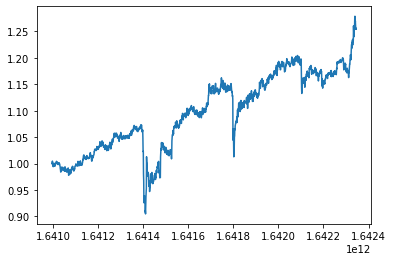

In [15]:
short = "SLP-PERP"
long = "AXS-PERP"
adfa = ls_index("2022-01-01", long, short, "15m")
plt.plot(adfa['time'],adfa['returns'])
a,b,c = analyze(adfa, long, short)
print(f"{long}/{short}")
print(f"max drawdown:{a}") 
print(f"max return: {b}")
print(f"current return: {c}")
print(f"% to max: {b-c}")

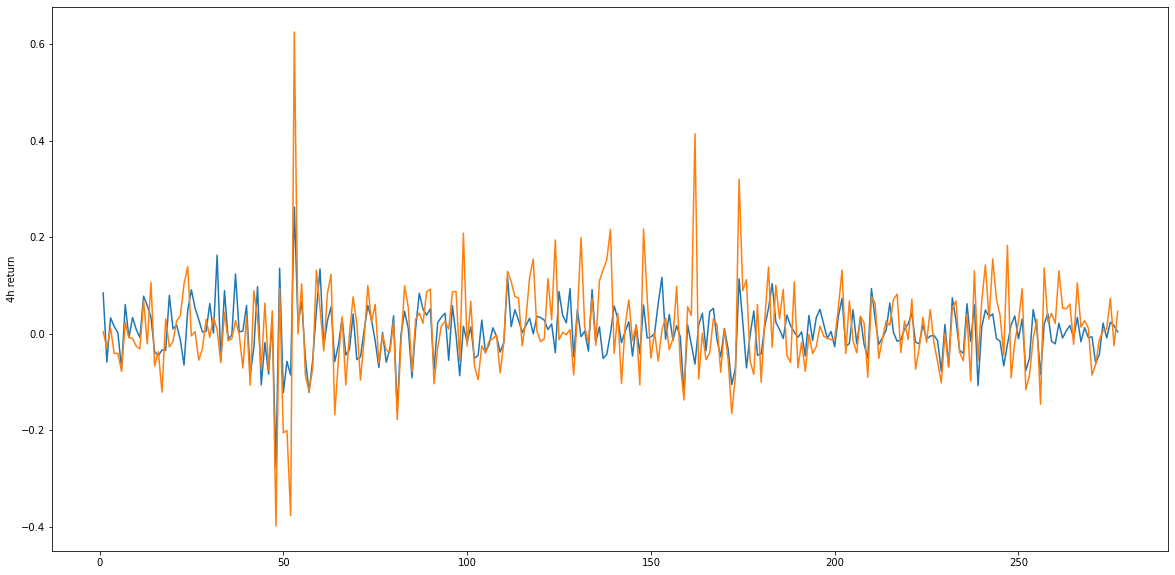

[0.98487375]


In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

eth = read_historical_data("2021-04-01", "ETH-PERP","1d")
luna = read_historical_data("2021-04-01", "LUNA-PERP","1d")
eth_r = eth.close.pct_change()[1:]
luna_r = luna.close.pct_change()[1:]
plt.figure(figsize=(20,10))
eth_r.plot()
luna_r.plot()
plt.ylabel("4h return")
plt.show()


x = np.array(eth_r).reshape((-1,1))
y = np.array(luna_r)
model = LinearRegression().fit(x,y)
print(model.coef_)


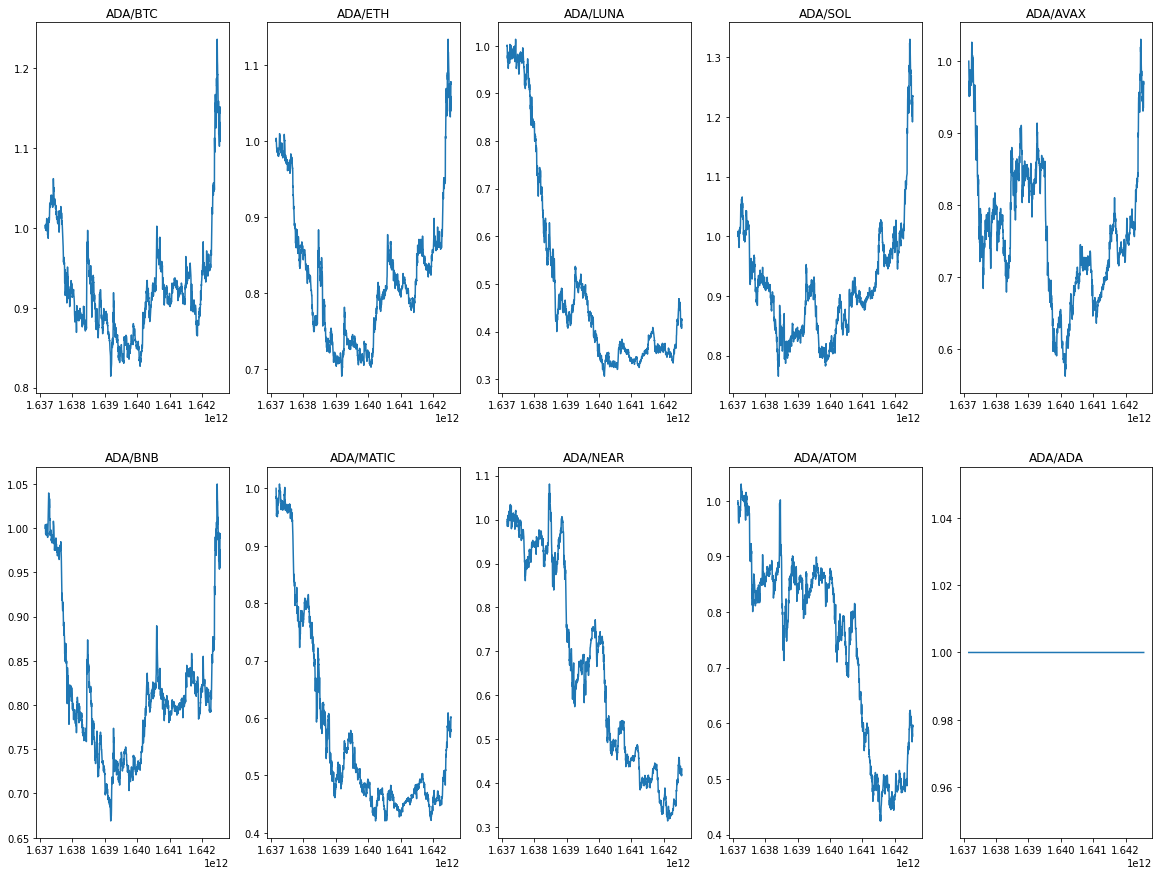

In [440]:
f = compare("2022-16-01","ADA-PERP",res="1h",long=True)

In [437]:
f

,pair,max_drawdown,max_return,current_return
0,ADA/BTC,-5.54,27.89,26.791683
1,ADA/ETH,-4.43,32.51,31.215091
2,ADA/LUNA,-4.02,26.74,25.929266
3,ADA/SOL,-0.29,43.16,41.801333
4,ADA/AVAX,-3.41,46.08,44.624727
5,ADA/BNB,-1.36,25.66,24.585508
6,ADA/MATIC,-3.42,25.72,24.575050
7,ADA/NEAR,-31.17,8.47,-9.935397
8,ADA/ATOM,-25.05,7.35,-0.318487
9,ADA/ADA,0.00,0.00,0.000000


In [8]:
weight = {'ETH' : -0.25 , 'SOL': 0.2, 'AVAX': 0.2, 'LUNA' :0.3, 'BTC' : -0.15, 'NEAR' : 0.25, 'ONE': 0.25, 'ATOM': 0.2}
weights = {'ETH' : -0.2 , 'LUNA' :0.5, 'NEAR' : 0.5, 'ONE': 0.5, 'SOL': -0.3}
foan_sal = {'FTM' : 0.25 , 'ONE' :0.25, 'ATOM' : 0.25, 'NEAR': 0.25, 'SOL': -0.33, 'AVAX': -0.33 , 'LUNA': -0.33}

sol_srm_ray = {'ADA' : 2 , 'LUNA':-0.25, 'ETH':-0.5,'BTC' : -0.5,'AVAX':-0.25,'SOL':-0.5}
port = {'ETH' : 0.5 , 'SOL': 0.2, 'AVAX': 0.1, 'LUNA' :0.1, 'BTC' : 0.10}

sol = {'SOL' : 1 , 'OXY': -0.2, 'FIDA': -0.2, 'ATLAS' : -0.2, 'SRM' : -0.2, 'RAY' : -0.2}

i1 = {'ETH' : 0.2 ,'AVAX':0.25, 'SOL': 0.15, 'LUNA' :0.25, 'MAPS' : -0.25, 'OXY': -0.1, 'FIDA': -0.1, 'ATLAS': -0.1, 'SLP':-.1}
i2 = {'LOOKS' : 2.5 , 'SOS': -2.5}
long_btc_eth_short_shit = {'ETH' : 0.5 ,'BTC':0.5, 'SOL': -0.25, 'LUNA' : -0.25,  'AVAX': -0.25, 'SLP':-.25}
i2 = {'ATOM' :5 , 'DOT': -2, 'ADA':-2.5}
wl = [abs(i) for i in i2.values()]
print(sum(wl))



9.5


In [11]:
from datetime import date, timedelta

def index(weights, lookback_window = 30, starting_balance = 1000):
    resolution = '1m'
    start_date = date.today() - timedelta(lookback_window)
    ohlc_data = dict()
    holding = dict()
    for ticker, weight in weights.items():
        try:
            ohlc = read_historical_data(start_date, f"{ticker}-PERP", resolution)
        except FileNotFoundError as e:
            ohlc_filename = download_historical_data(start_date, f"{ticker}-PERP", resolution)
            ohlc = read_historical_data(start_date, f"{ticker}-PERP", resolution)
        
        holding[ticker] = weight * starting_balance / ohlc['open'][0]
        ohlc['return'] = ohlc['close'] / ohlc['open'][0]
        if holding[ticker] < 0:
            ohlc['value'] = weight * starting_balance * (-1/ohlc['return'])
            ohlc['pnl'] = ohlc['value'] + weight*starting_balance

        else:
            ohlc['value'] = weight * starting_balance * ohlc['return']
            ohlc['pnl'] = ohlc['value'] - weight*starting_balance

        ohlc_data[ticker] = ohlc
    windowlength = len(list(ohlc_data.values())[0]) - 1
    va = [0]*(windowlength)
    plt.figure(figsize=(15,10))
    for k,v in ohlc_data.items():
        for i in range(len(va)):
            va[i] += v['pnl'][i]
        plt.plot(v['return'], label = k)
    pct_return = [(i/starting_balance) + 1 for i in va]
    plt.plot(pct_return, color='black', label='return')
    plt.legend()
    print(f"min drawdown: {round(100*(min(pct_return) - 1),2)}%")
    print(f"max return: {round(100*(max(pct_return) - 1),2)}%")
    print(f"current return: {round(100*(pct_return[-1] - 1),2)}%")
    for k,v in weights.items():
        print(f"{k} : {v}")

    return ohlc_data, va



min drawdown: -5.58%
max return: 55.59%
current return: 40.5%
ATOM : 5
DOT : -2
ADA : -2.5


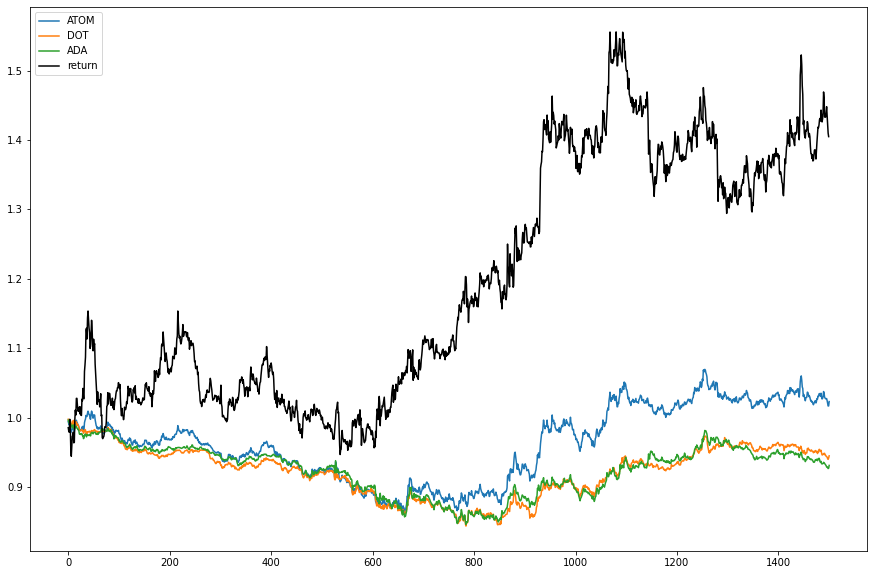

In [12]:
df, pnl = index(i2, lookback_window=1, starting_balance=2000)

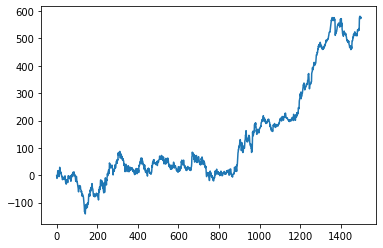

In [35]:
plt.plot(pnl)

In [476]:
import ccxt


ftx = ccxt.ftx()
exchange_id = 'ftx'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': '6rUlTDVKecEnNQv4t-yqv5PNvmMhdc1klR2wdPxq',
    'secret': 'ta-Y95hA99ZfRz0Pp93fG8Q6L6WP7qDAiGCulthl',
})

ftx_markets = ftx.load_markets()
print(ftx.fetch_ticker('ADA-PERP')['ask'])
# print(exmo.id, exmo.create_market_sell_order('BTC/USD', 1))


1.39819


In [477]:
print(ftx_markets['ADA/USD:USD']['info']['last'])

1.39872


In [481]:
import time
import threading

def fetch_prices(ftx, name):
    # markets = ftx.load_markets()
    last_price = dict()
    for ticker, weight in weights.items():
        # price = markets[f"{ticker}/USD:USD"]['info']['last']
        price = ftx.fetch_ticker(f"{ticker}-PERP")['ask']
        last_price[ticker] = (price)
        with open(f"{name}/{ticker}.csv", 'a') as f:
            f.write("%s\n"%(price,))
            f.close()

        
def create_index(ftx,  weights, amount):
    import csv,os
    name = input("Index Name?: ")
    os.mkdir(name)
    with open(f"{name}/weights.csv", 'a') as f:
        for key in weights.keys():
            f.write("%s,%s,%s\n"%(key,weights[key], weights[key]*amount))
        f.close()
    
    
    track = True
    while track:
        fetch_prices(ftx, name)
        time.sleep(60)
        t = input("Stop")
        if t == "x":
            track = False

    
            
create_index(ftx, sol_srm_ray, 1000)
    


In [478]:
!rm -rf test